In [4]:
import os
from pathlib import PosixPath
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from collections import OrderedDict

tqdm.pandas(ncols=50)

## Data preparation

In [6]:
df = None

for path in [
    'data/trained3_payloads_1000traj_2/*.csv',
]:

    for file in glob.glob(path):
        df_ = pd.read_csv(file, index_col=0)

        if df is None:
            df = df_
        else:
            # Merge rows
            df = pd.concat([df, df_], ignore_index=True)


def extend_columns(x):
    run_args = eval(x['run_args'])

    res = dict(
        command_x=run_args['command']['x'],
        command_y=run_args['command']['y'],
        command_t=run_args['command']['t'],
        command_h=run_args['command']['h'],
        terrain=run_args['env']['terrain'],
        force=run_args['env']['force'],
        policy=run_args['env']['policy'],
    )

    total_power = 0
    for i, power in enumerate(list(map(float, x['power'][1:-1].split()))):
        res[f'power_{i}'] = power
        total_power += power

    res['power'] = total_power

    joint_forces = []
    for i, joint_force in enumerate(list(map(float, x['joint_forces'][1:-1].split()))):
        res[f'joint_forces_{i}'] = joint_force
        joint_forces.append(joint_force)

    res['joint_forces'] = np.mean(joint_forces)

    res['perturbation_force_start'], res['perturbation_force_end'] \
        = map(int, x['perturbation_force_bound'][1:-1].split(','))

    res['perturbation_force_window'] = res['perturbation_force_end'] - res['perturbation_force_start']

    total_height_diff = 0
    for i, height_diff in enumerate(list(map(float, x['height_diff'][1:-1].split()))):
        res[f'height_diff_{i}'] = height_diff
        total_height_diff += height_diff

    res['height_diff'] = total_height_diff

    return res


df = pd.concat([df.progress_apply(lambda x: pd.Series(extend_columns(x)), axis=1), df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

df.columns.duplicated().any()

100%|█████| 18000/18000 [00:04<00:00, 4168.09it/s]


False

In [11]:
df.groupby(['policy', 'terrain']).size()

policy                                         terrain             
trained_3_torque_joint_force_randomize_weight  cassiepede_rectangle    18000
dtype: int64

### Drifts

In [9]:
df_ = df.copy()

# Choose policy and force (force = 0 for standing metric)
df_ = df_[(df_['policy'] == 'trained_3_torque_joint_force_randomize_weight')]

# Group and aggregate
df_ = df_.groupby(['command_x', 'command_y', 'command_t', 'terrain']).agg(
    {'odometry_x': 'mean', 'odometry_y': 'mean', 'orientation_error': 'mean', 'episode_length': 'mean'})

df_ = df_.reset_index()

# Index will be x-axis, columns will be y-axis and values will be x-y cell
df_ = df_.pivot(index='terrain', columns=['command_x', 'command_y', 'command_t'],
                values=['odometry_x', 'odometry_y', 'orientation_error'])

# Compute error (with traj len 1000 and policy rate 50hz, it should have covered 20m)
df_[('odometry_x', 1, 0, 0)] = 20 - df_[('odometry_x', 1, 0, 0)]
df_[('odometry_y', 0, 0.25, 0)] = 5 - df_[('odometry_y', 0, 0.25, 0)]
df_['orientation_error'] = -df_['orientation_error']
# Reorder columns
columns = []
for command in (0, 0, 0), (1, 0, 0), (0, 0.25, 0), (0, 0, 15):
    for odom in 'odometry_x', 'odometry_y', 'orientation_error':
        columns.append((odom, *command))

df_ = df_.reindex(columns, axis=1)

In [10]:
df_

,odometry_x,odometry_y,orientation_error,odometry_x,odometry_y,orientation_error,odometry_x,odometry_y,orientation_error,odometry_x,odometry_y,orientation_error
command_x,0,0,0,1,1,1,0,0,0,0,0,0
command_y,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.00,0.00,0.00
command_t,0,0,0,0,0,0,0,0,0,15,15,15
terrain,,,,,,,,,,,,
cassiepede_rectangle,0.070332,0.095262,1.199325,1.55497,0.907693,0.569379,0.206592,0.31152,-0.353392,0.091005,0.375103,6.300302


In [6]:
df_.to_csv('table.csv', float_format='%.2f', header=False, index=False, sep=' ')

In [7]:
row = ''

y_label = 'Load carrier'
y_ticks = ['A', 'B', 'C', 'D']

for i in range(len(df_)):

    if i == len(df_) - 1:
        row += r'\multicolumn{1}{l|}{\parbox[t]{2mm}{\multirow{-4}{*}{\rotatebox[origin=c]{90}{' + y_label + '}}}} &\n'

    else:
        row += '\multicolumn{1}{c|}{} &\n'

    for j in range(len(df_.columns)):
        if j == 0:
            row += '  \multicolumn{1}{c|}{' + y_ticks[i] + '}' + ' &\n'
        elif j % 3 == 0:
            row += '  \multicolumn{1}{c|}{} &\n'

        if j == len(df_.columns) - 1:
            row += '  \multicolumn{1}{c|}{' + f'{df_.iloc[i, j]:.2f}' + r'} \\ \cline{2-5} \cline{7-9} \cline{11-13} \cline{15-17}' + '\n'
        else:
            row += "  \multicolumn{1}{c|}{" + f'{df_.iloc[i, j]:.2f}' + "}" + ' &\n'
print(row)

\multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{A} &
  \multicolumn{1}{c|}{0.14} &
  \multicolumn{1}{c|}{0.04} &
  \multicolumn{1}{c|}{0.45} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{1.19} &
  \multicolumn{1}{c|}{0.79} &
  \multicolumn{1}{c|}{1.05} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{0.61} &
  \multicolumn{1}{c|}{0.79} &
  \multicolumn{1}{c|}{-0.19} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{-0.24} &
  \multicolumn{1}{c|}{-0.20} &
  \multicolumn{1}{c|}{10.95} \\ \cline{2-5} \cline{7-9} \cline{11-13} \cline{15-17}
\multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{B} &
  \multicolumn{1}{c|}{0.21} &
  \multicolumn{1}{c|}{-0.13} &
  \multicolumn{1}{c|}{-0.60} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{1.25} &
  \multicolumn{1}{c|}{0.63} &
  \multicolumn{1}{c|}{0.44} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{0.38} &
  \multicolumn{1}{c|}{1.27} &
  \multicolumn{1}{c|}{-2.43} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{-0.79} &
  \multicolumn{1}{c|}

## Failure rate

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_14520/2514512980.py:25: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(data=df_, x='force', y='failure_rate', hue='terrain', errorbar=('ci', 95), palette=cmap)


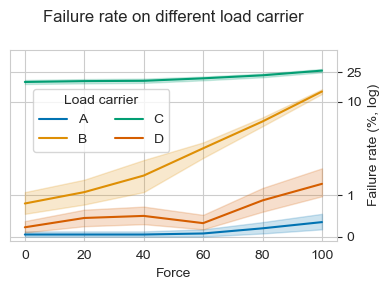

In [11]:
plt.figure(figsize=(4, 3))

df_ = df.copy()


def weighted_failure_rate(length, threshold):
    if length >= threshold:
        return 0.0
    elif length >= threshold * 0.9:
        return 50.0
    elif length >= threshold * 0.8:
        return 75.0
    else:
        return 100.0


df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0
# df_['failure_rate'] = (100 - df_['episode_length']) / 100.0
# df_['failure_rate'] = df_['episode_length'].apply(lambda x: weighted_failure_rate(x, 1000))

df_ = df_[df_.policy == 'trained_3_torque_joint_force_randomize_weight']

cmap = sns.color_palette('colorblind')

ax = sns.lineplot(data=df_, x='force', y='failure_rate', hue='terrain', errorbar=('ci', 95), palette=cmap)

ax.set_ylabel('Failure rate (%, log)')
ax.set_xlabel('Force')

handles, labels = ax.get_legend_handles_labels()

order_idx = [6, 0]

ax.legend(handles=handles, labels=['A', 'B', 'C', 'D'], title='Load carrier')

sns.move_legend(ax, "upper left", ncols=2, bbox_to_anchor=(0.05, 0.83))
plt.yscale('symlog')
plt.ylim(-0.1, 50)

ax.set_yticks([0, 1, 10, 25])
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
ax.set_title('Failure rate on varying number of robots', pad=20)

ax.set_title('Failure rate on different load carrier', pad=20)

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')
